In [193]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

torch.manual_seed(43)
np.random.seed(43)

In [194]:
print(torch.__version__)

2.9.1+cu130


In [195]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [196]:
class FiniteElement1D:
    def __init__(self):
        pass

    # Função para obtenção das bases e dos pesos
    def shg_w(self, nint, nen):
        shg1 = np.zeros((nen, nint)) # Funções de base
        shg2 = np.zeros((nen, nint)) # Derivadas das funções de base
        if nint == 2:
            pt = np.array([-np.sqrt(3)/3, np.sqrt(3)/3])
            w = np.array([1.0, 1.0])
        elif nint == 3:
            pt = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
            w = np.array([5/9, 8/9, 5/9])
        elif nint == 4:
            pt = np.array([-np.sqrt(3/7 + (2/7)*np.sqrt(6/5)), -np.sqrt(3/7 - (2/7)*np.sqrt(6/5)),
                        np.sqrt(3/7 - (2/7)*np.sqrt(6/5)),
                        np.sqrt(3/7 + (2/7)*np.sqrt(6/5))])
            w = np.array([(18 - np.sqrt(30))/36, (18 + np.sqrt(30))/36, (18 + np.sqrt(30))/36, (18 - np.sqrt(30))/36])
        elif nint == 5:
            pt = np.array([-(1/3)*np.sqrt(5 + 2*np.sqrt(10/7)), -(1/3)*np.sqrt(5 - 2*np.sqrt(10/7)), 0,
                        (1/3)*np.sqrt(5 - 2*np.sqrt(10/7)), (1/3)*np.sqrt(5 + 2*np.sqrt(10/7))])
            w = np.array([(322 - 13*np.sqrt(70))/900, (322 + 13*np.sqrt(70))/900, 128/225,
                        (322 + 13*np.sqrt(70))/900, (322 - 13*np.sqrt(70))/900])
            
        for l in range(nint):
            t = pt[l]
            if nen == 2:
                shg1[0, l] = 0.5 * (1 - t)
                shg1[1, l] = 0.5 * (1 + t)
                # Derivadas para nen = 2
                shg2[0, l] = -0.5
                shg2[1, l] = 0.5
            elif nen == 3:
                shg1[0, l] = 0.5 * t * (t - 1)
                shg1[1, l] = - (t - 1) * (t + 1)
                shg1[2, l] = 0.5 * t * (t + 1)
                # Derivadas para nen = 3
                shg2[0, l] = t - 0.5
                shg2[1, l] = -2 * t
                shg2[2, l] = t + 0.5
            elif nen == 4:
                shg1[0, l] = -9/16*(t + 1/3)*(t - 1/3)*(t - 1)
                shg1[1, l] = 27/16*(t + 1)*(t - 1/3)*(t - 1)
                shg1[2, l] = -27/16*(t + 1)*(t + 1/3)*(t - 1)
                shg1[3, l] = 9/16*(t + 1)*(t + 1/3)*(t - 1/3)
                # Derivadas para nen = 4
                shg2[0, l] = -27/16 * t**2 + 9/8 * t + 1/16
                shg2[1, l] = 81/16 * t**2 - 9/8 * t - 27/16
                shg2[2, l] = -81/16 * t**2 - 9/8 * t + 27/16
                shg2[3, l] = 27/16 * t**2 + 9/8 * t - 1/16
            elif nen == 5:
                shg1[0, l] = (2/3)*(t + 1/2)*t*(t - 1/2)*(t - 1)
                shg1[1, l] = -(8/3)*(t + 1)*t*(t - 1/2)*(t - 1)
                shg1[2, l] = 4*(t + 1)*(t + 1/2)*(t - 1/2)*(t - 1)
                shg1[3, l] = - (8/3)*(t + 1)*(t + 1/2)*t*(t - 1)
                shg1[4, l] = (2/3)*(t + 1)*(t + 1/2)*t*(t - 1/2)
                # Derivadas para nen = 5
                shg2[0, l] = 8/3 * t**3 - 2 * t**2 - 1/3 * t + 1/6
                shg2[1, l] = -32/3 * t**3 + 4 * t**2 + 16/3 * t - 4/3
                shg2[2, l] = 16 * t**3 - 10 * t
                shg2[3, l] = -32/3 * t**3 - 4 * t**2 + 16/3 * t + 4/3
                shg2[4, l] = 8/3 * t**3 + 2 * t**2 - 1/3 * t - 1/6

        return shg1, shg2, w
    
    # Construção das matrizes K e F
    def make_matrices(self, f, a, b, nel, nint, nen, u_a, u_b):
        # Parâmetros
        h = (b - a) / nel
        # Funções base e pesos
        shg1, shg2, w = self.shg_w(nint, nen)
        tam = (nen-1)*nel+1
        x_global = np.linspace(a, b, tam)

        K = np.zeros((tam, tam))
        F = np.zeros(tam)
        
        # Algoritmo apresentado em aula para construção das matrizes locais e globais
        for n in range(nel):
            Ke = np.zeros((nen, nen))
            Fe = np.zeros(nen)
            idx_start, idx_end = n*(nen - 1), n*(nen - 1) + nen
            indices = list(range(idx_start, idx_end))
            xl = x_global[idx_start:idx_end]
            for l in range(nint):
                xx = 0
                for i in range(nen):
                    xx += shg1[i, l]*xl[i]
                for j in range(nen):
                    Fe[j] += f(xx)*shg1[j, l]*w[l]*(h/2)
                    for i in range(nen):
                        Ke[i, j] += shg2[i, l]*(2/h)*shg2[j, l]*(2/h)*w[l]*(h/2)
        
            for i in range(nen):
                F[indices[i]] += Fe[i]
                for j in range(nen):
                    K[indices[i], indices[j]] += Ke[i, j]

        # right Dirichlet boundary condition
        K[0, :] = 0
        K[0, 0] = 1
        F[0] = u_a

        # left Dirichlet boundary condition
        K[-1, :] = 0
        K[-1, -1] = 1
        F[-1] = u_b
        
        return K, F

    def erro_L2(self, u, u_exata, a, b, nel, nint, nen):
        erul2 = 0
        h = (b - a)/nel
        shg1, _, w = self.shg_w(nint, nen)
        tam = (nen-1)*nel+1
        x_global = np.linspace(a, b, tam)
        
        for n in range(nel):
            idx_start, idx_end = n*(nen - 1), n*(nen - 1) + nen
            indices = list(range(idx_start, idx_end))
            xl = x_global[idx_start:idx_end]
            eru = 0
            for l in range(nint):
                uh = 0
                xx = 0
                for i in range(nen):
                    uh += shg1[i, l]*u[indices[i]]
                    xx += shg1[i, l]*xl[i]
                eru += ((u_exata(xx) - uh)**2)*w[l]*(h/2)
            erul2 += eru
        
        return np.sqrt(erul2)


In [197]:
class FullyConnected(torch.nn.Module):
    def __init__(self, n_hidden, n_layer):
        super(FullyConnected, self).__init__()
        self.hidden1 = torch.nn.Linear(1, n_hidden).double().to(device)
        torch.nn.init.xavier_uniform_(self.hidden1.weight, gain=1).to(device)
        torch.nn.init.ones_(self.hidden1.bias).to(device)

        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden).double().to(device)    # hidden layer
        torch.nn.init.xavier_uniform_(self.hidden2.weight, gain=1).to(device)
        torch.nn.init.ones_(self.hidden2.bias).to(device)

        self.predict = torch.nn.Linear(n_hidden, 1).double().to(device)   # output layer
        torch.nn.init.xavier_uniform_(self.predict.weight, gain=1).to(device)
        torch.nn.init.ones_(self.predict.bias).to(device)

        self.bn1 = torch.nn.BatchNorm1d(num_features=n_hidden).double().to(device)

        self.num_layers = n_layer
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, train=False):
        x = self.hidden1(x)
        # x = self.bn1(x)
        x = self.tanh(x)
        # x = self.dropout(x)

        # for creating number of layers dynamically
        for i in range(self.num_layers):
            x = self.hidden2(x)
            # x = self.bn1(x)
            x = self.tanh(x)
            # x = self.dropout(x)
        x = self.predict(x)
        return x

In [198]:
def get_der(u, t, order=2):
    # calculating derivation using AD
    
    # Calcula primeira derivada
    du = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    
    if du is None:
        return torch.zeros_like(t, requires_grad=True)
    
    # Calcula segunda derivada se necessário
    if order >= 2:
        d2u = torch.autograd.grad(du, t, grad_outputs=torch.ones_like(du), create_graph=True, allow_unused=True)[0]
        if d2u is None:
            return torch.zeros_like(t, requires_grad=True)
        return d2u
    
    return du

def loss_f(u, t, f, order=2):
    # u, t, f are in (number_of_samples,1) shape. Residue for: -u'' = f → u'' + f = 0
    
    # Calcula a segunda derivada
    d2u = get_der(u, t, order=2)
    
    # Garante que f tem a mesma forma que t
    if isinstance(f, (int, float)):
        f = torch.full_like(t, f)
    elif f.shape != t.shape:
        f = f.reshape(-1, 1) if len(f.shape) == 1 else f
        if f.shape[0] != t.shape[0]:
            # Se f for um único valor, repete para todos os pontos
            if f.numel() == 1:
                f = f.repeat(t.shape[0], 1)
            else:
                raise ValueError(f"Dimensão de f ({f.shape[0]}) não corresponde a t ({t.shape[0]})")
    
    # Resíduo: u'' + f (porque -u'' = f → u'' + f = 0)
    residual = d2u + f
    
    # Retorna MSE do resíduo
    return torch.mean(residual**2)

def loss_mse(left, lv, right, rv, model):
    x_bc = torch.tensor([[left], [right]], dtype=torch.double, device=device)
    y_bc = torch.tensor([[lv], [rv]], dtype=torch.double, device=device)

    u_pred = model(x_bc)

    # l = torch.sqrt((torch.tensor([lv]).to(device)-model(torch.tensor([left]).double().to(device)))**2 + (torch.tensor([rv]).to(device)-model(torch.tensor([right]).double().to(device)))**2)

    return torch.mean((u_pred - y_bc)**2)

def loss_fem(A, F, u):
    # l = torch.sqrt(torch.mean((torch.matmul(torch.tensor(A).to(device), u)-torch.tensor(F).to(device))**2))
    residuo = torch.matmul(torch.tensor(A).to(device), u)-torch.tensor(F).to(device)
    l = torch.norm(residuo, p=2)
    return l

In [199]:
# This file contain different training methods for neural network. e.g.: train pinn alone, train pinn and fem together etc

class train_model_base():
    def __init__(self, model):
        self.model = model.to(device)
        self.train_data = None

    def _calculate_loss(self, u):
        pass

    def train(self, data, epochs=1000, opt=None):
        self.train_data = data.to(device)
        self.model.train()
        if opt is None:
            opt = torch.optim.Adam(self.model.parameters(), lr = 0.0003)
        self.loss_h = []
        for epoch in range(epochs):
            u = self.model(self.train_data)
            loss_epoch = self._calculate_loss(u)
            opt.zero_grad()
            loss_epoch.backward()
            opt.step()
            if epoch % 1000 == 0:
                print(epoch, loss_epoch.detach().cpu().numpy())
            self.loss_h.append(loss_epoch.detach().cpu().numpy())
        return self.loss_h

    def predict(self, p_in_data):
        self.model.eval()
        return self.model(p_in_data)

    def plot_training(self):
        plt.plot(self.loss_h)

class train_pinn_1d(train_model_base):
    def __init__(self, model, f, l_bc, r_bc):
        train_model_base.__init__(self, model)
        self.force = f
        self.left_bc = l_bc
        self.right_bc = r_bc
    def _calculate_loss(self, u):
        l = loss_f(u, self.train_data, self.force) + loss_mse(0.0, self.left_bc, 2.0, self.right_bc, self.model)
        return l

class train_fem_loss_1d(train_model_base):
    def __init__(self, model, A, F):
        train_model_base.__init__(self, model)
        self.A = A
        self.F = F
    def _calculate_loss(self, u):
        l = loss_fem(self.A, self.F, u)
        return l

In [200]:
def plot_data(np_array1=None, np_array2=None, np_array3=None, savefile_name=None, labels=None):
    plt.figure(figsize=(9, 6))

    Var1X, Var1Y = np_array1[:, 0], np_array1[:, 1]
    Var2X, Var2Y = np_array2[:, 0], np_array2[:, 1]
    Var3X, Var3Y = np_array3[:, 0], np_array3[:, 1]

    x_min, x_max = np.min(Var3X), np.max(Var3X)
    y_min, y_max = np.min(Var3Y), np.max(Var3Y)

    plt.plot(Var1X, Var1Y, label=labels[0], color="blue", linestyle="dashed", marker="s", markeredgecolor="blue", markerfacecolor="blue", markersize=5)

    plt.plot(Var2X, Var2Y, label=labels[1], color="red", linestyle="solid", marker="*", markeredgecolor="red", markerfacecolor="red", markersize=5)

    plt.plot(Var3X, Var3Y, label=labels[2], color="green", linestyle="solid", marker="p", markeredgecolor="green", markerfacecolor="green", markersize=5)

    plt.xlabel(labels[3])
    plt.ylabel(labels[4], labelpad=0.001)

    print("Limits are ", x_min, x_max, y_min, y_max)

    plt.grid(ls='--', alpha=0.5, c='#ccc')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'img/fem_nn/{savefile_name}.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()
    plt.close()

In [201]:
def plot_loss(loss_1, loss_2, nome_arquivo):
    plt.plot(loss_1, label='Train Loss PINN', color='blue', alpha=0.7)
    plt.plot(loss_2, label='Train Loss FEM-NN', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    # plt.savefig(f'img/fem_nn/{nome_arquivo}.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()

# Usando pontos nodais do FEM como pontos de colocação para PINN

\begin{align*}
    &-u''(x) = f(x), \\
    &u(0) = a, u(2) = b.
\end{align*}

Um exemplo simples de Poisson é testado com PINN combinado com função perda baseada em FEM.

## Iniciando o caso polinomial: $ f(x) = 6(x-1)^{5} + 2(x-1) $

In [202]:
l_bc, r_bc = 10/21, -10/21          # Condições de contorno

# Definição da fonte externa
def f(x): return 6*(x-1)**5 + 2*(x-1)

# Solução exata
def sol_exata(x): return -((x-1)**7)/7 - ((x-1)**3)/3

modelo_fem = FiniteElement1D()      # Definindo modelo de elementos finitos em 1D

[a, b] = [0, 2]                     # Definição do domínio
nint, nen = 2, 2                    # número de pontos de integração, número de elmentos nodais
nel = 9                             # número de elementos no domínio
nodes_d = (nen-1)*nel+1             # número total de nós

# Criando matrizes para função perda baseada em FEM
A, F = modelo_fem.make_matrices(f, a, b, nel, nint, nen, l_bc, r_bc)
F = F.reshape(-1, 1)

In [203]:
model_1 = FullyConnected(10, 3).to(device)
# Copiando modelo para ter a mesma inicialização para ambos os modelos
model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)
model_4 = copy.deepcopy(model_1)

In [204]:
data_fem = torch.linspace(0, 2, nodes_d).reshape(-1, 1).requires_grad_(True).double().to(device)

In [205]:
force = 6*(data_fem-1)**5 + 2*(data_fem-1)
force = force.detach().clone().requires_grad_(True).to(device)

epoch = 2200

In [206]:
# Treino usando PINN
pinn_trainer = train_pinn_1d(model_1, force, l_bc, r_bc)
loss_1 = pinn_trainer.train(data_fem, epochs=epoch)

0 17.309236198109193
1000 6.348656332037125
2000 0.02348690911752238


In [207]:
# Treino usando FEM-NN
fem_loss_trainer = train_fem_loss_1d(model_2, A, F)
loss_2 = fem_loss_trainer.train(data_fem, epochs=epoch)

0 2.3286881807466453
1000 1.081356064961705
2000 0.024830365362974866


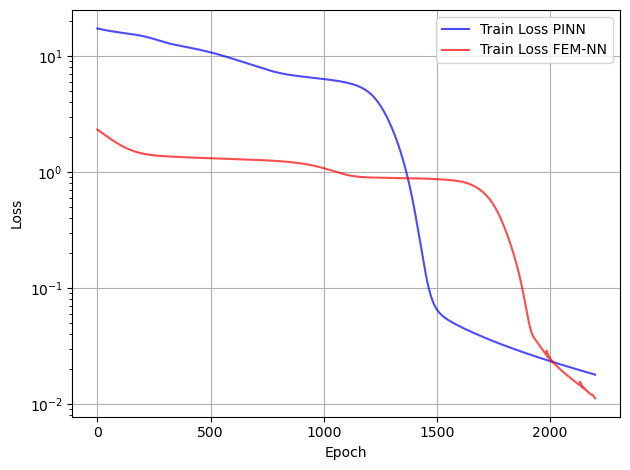

In [208]:
nome_arquivo = f"dataset1_simples_loss_{epoch}"
plot_loss(loss_1, loss_2, nome_arquivo)

In [209]:
# Predições
test_in = torch.linspace(0, 2, 129).reshape(-1, 1).to(device)
u_exata = np.asarray([sol_exata(x) for x in test_in.detach().cpu().numpy()])

test_out_1 = pinn_trainer.predict(test_in.double())
test_out_2 = fem_loss_trainer.predict(test_in.double())

In [210]:
mse_pinn = mean_squared_error(u_exata, test_out_1.detach().cpu().numpy())
mae_pinn = mean_absolute_error(u_exata, test_out_1.detach().cpu().numpy())
r2_pinn = r2_score(u_exata, test_out_1.detach().cpu().numpy())
rel_err_pinn = np.linalg.norm(u_exata - test_out_1.detach().cpu().numpy())/np.linalg.norm(u_exata)

mse_femnn = mean_squared_error(u_exata, test_out_2.detach().cpu().numpy())
mae_femnn = mean_absolute_error(u_exata, test_out_2.detach().cpu().numpy())
r2_femnn = r2_score(u_exata, test_out_2.detach().cpu().numpy())
rel_err_femnn = np.linalg.norm(u_exata - test_out_2.detach().cpu().numpy())/np.linalg.norm(u_exata)

metrics_summary = (
    {'Modelo': 'PINN', 'MSE': mse_pinn, 'MAE': mae_pinn, 'ER': rel_err_pinn, 'R2': r2_pinn},
    {'Modelo': 'FEM-NN', 'MSE': mse_femnn, 'MAE': mae_femnn, 'ER': rel_err_femnn, 'R2': r2_femnn}
)

print(metrics_summary[0])
print(metrics_summary[1])

results = pd.DataFrame(metrics_summary)
print(results[['Modelo', 'MSE', 'MAE', 'ER', 'R2']])

{'Modelo': 'PINN', 'MSE': 0.0005537601018935037, 'MAE': 0.019390843882717078, 'ER': np.float64(0.14193722716847512), 'R2': 0.9798538258962172}
{'Modelo': 'FEM-NN', 'MSE': 7.647130572362606e-07, 'MAE': 0.0007190360232389209, 'ER': np.float64(0.005274541803399511), 'R2': 0.9999721792120129}
   Modelo           MSE       MAE        ER        R2
0    PINN  5.537601e-04  0.019391  0.141937  0.979854
1  FEM-NN  7.647131e-07  0.000719  0.005275  0.999972


Limits are  0.0 2.0 -0.4761905 0.4761905


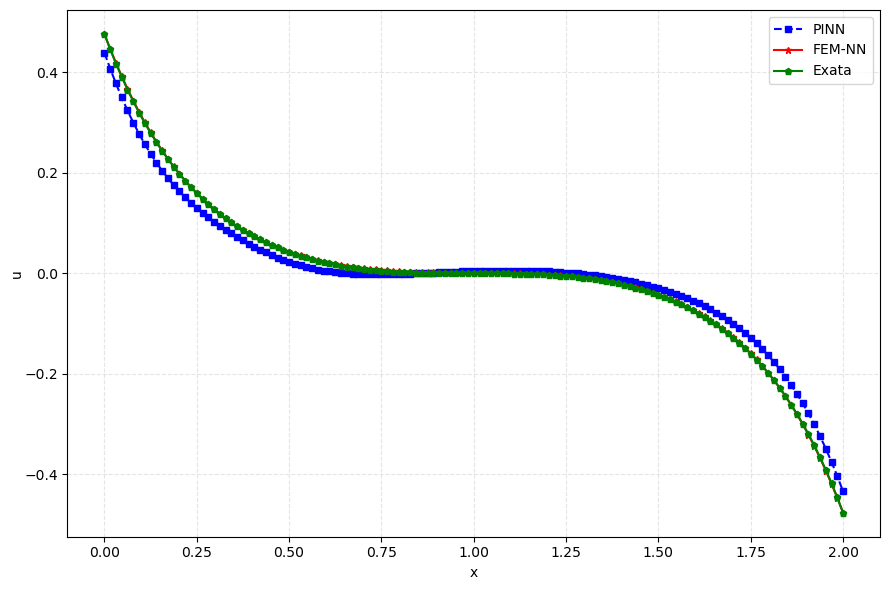

In [211]:
var1 = np.concatenate((test_in.detach().cpu().numpy(), test_out_1.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((test_in.detach().cpu().numpy(), test_out_2.detach().cpu().numpy()), axis=1)
var3 = np.concatenate((test_in.detach().cpu().numpy(), u_exata), axis=1)

plot_data(var1, var2, var3, f"dataset1_simples_{epoch}", ["PINN", "FEM-NN", "Exata", "x", "u"])

# Iniciando o caso oscilatório $f(x) = -2\pi^{2}\cos(2\pi x)$

In [212]:
l_bc, r_bc = 0, 0                   # Condições de contorno

# Definição da fonte externa
def f(x): return -2*(np.pi**2)*np.cos(2*np.pi*x)

# Solução exata
def sol_exata(x): return np.sin(np.pi*x)**2

modelo_fem = FiniteElement1D()      # Definindo modelo de elementos finitos em 1D

[a, b] = [0, 2]                     # Definição do domínio
nint, nen = 5, 5                    # número de pontos de integração, número de elmentos nodais
nel = 9
nodes_d = (nen-1)*nel+1             # número total de nós

# Criando matrizes para função perda baseada em FEM
A2, F2 = modelo_fem.make_matrices(f, a, b, nel, nint, nen, l_bc, r_bc)
F2 = F2.reshape(-1, 1)

In [213]:
data_fem = torch.linspace(0, 2, nodes_d).reshape(-1, 1).requires_grad_(True).double().to(device)

In [214]:
force = -2*(torch.pi**2)*torch.cos(2*torch.pi*data_fem)
force = force.detach().clone().requires_grad_(True).to(device)

epoch = 5000

In [215]:
# Treino usando PINN
pinn_trainer = train_pinn_1d(model_3, force, l_bc, r_bc)
loss_1 = pinn_trainer.train(data_fem, epochs=epoch)

0 201.7878693505472
1000 87.14878070095229
2000 5.094527091736778
3000 3.104880493283766
4000 0.35138794211332625


In [216]:
# Treino usando FEM-NN
fem_loss_trainer = train_fem_loss_1d(model_4, A2, F2)
loss_2 = fem_loss_trainer.train(data_fem, epochs=epoch)

0 5.236354767276446
1000 4.898716827674134
2000 2.3207373419001645
3000 0.020842059134216297
4000 0.013546227268975695


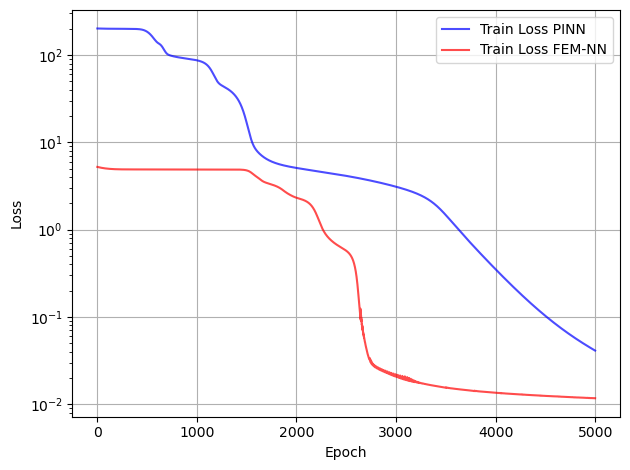

In [217]:
nome_arquivo = f"dataset1_simples_loss_{epoch}"
plot_loss(loss_1, loss_2, nome_arquivo)

In [218]:
# Predições
test_in = torch.linspace(0, 2, 129).reshape(-1, 1).to(device)
u_exata = np.asarray([sol_exata(x) for x in test_in.detach().cpu().numpy()])

test_out_1 = pinn_trainer.predict(test_in.double())
test_out_2 = fem_loss_trainer.predict(test_in.double())

In [219]:
mse_pinn = mean_squared_error(u_exata, test_out_1.detach().cpu().numpy())
mae_pinn = mean_absolute_error(u_exata, test_out_1.detach().cpu().numpy())
r2_pinn = r2_score(u_exata, test_out_1.detach().cpu().numpy())
rel_err_pinn = np.linalg.norm(u_exata - test_out_1.detach().cpu().numpy())/np.linalg.norm(u_exata)

mse_femnn = mean_squared_error(u_exata, test_out_2.detach().cpu().numpy())
mae_femnn = mean_absolute_error(u_exata, test_out_2.detach().cpu().numpy())
r2_femnn = r2_score(u_exata, test_out_2.detach().cpu().numpy())
rel_err_femnn = np.linalg.norm(u_exata - test_out_2.detach().cpu().numpy())/np.linalg.norm(u_exata)

metrics_summary = (
    {'Modelo': 'PINN', 'MSE': mse_pinn, 'MAE': mae_pinn, 'ER': rel_err_pinn, 'R2': r2_pinn},
    {'Modelo': 'FEM-NN', 'MSE': mse_femnn, 'MAE': mae_femnn, 'ER': rel_err_femnn, 'R2': r2_femnn}
)

print(metrics_summary[0])
print(metrics_summary[1])

results = pd.DataFrame(metrics_summary)
print(results[['Modelo', 'MSE', 'MAE', 'ER', 'R2']])

{'Modelo': 'PINN', 'MSE': 0.0004908194318154525, 'MAE': 0.01828439006025469, 'ER': np.float64(0.03631910338037321), 'R2': 0.9961031840240208}
{'Modelo': 'FEM-NN', 'MSE': 3.2020301217825855e-07, 'MAE': 0.0004121474070404613, 'ER': np.float64(0.0009276559847915681), 'R2': 0.9999974577774787}
   Modelo           MSE       MAE        ER        R2
0    PINN  4.908194e-04  0.018284  0.036319  0.996103
1  FEM-NN  3.202030e-07  0.000412  0.000928  0.999997


Limits are  0.0 2.0 0.0 1.0


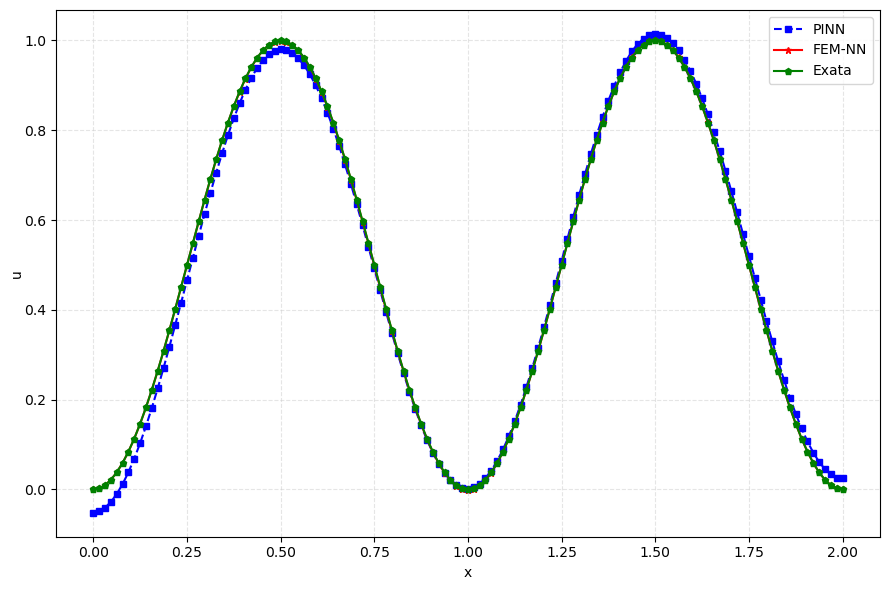

In [220]:
var1 = np.concatenate((test_in.detach().cpu().numpy(), test_out_1.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((test_in.detach().cpu().numpy(), test_out_2.detach().cpu().numpy()), axis=1)
var3 = np.concatenate((test_in.detach().cpu().numpy(), u_exata), axis=1)

plot_data(var1, var2, var3, f"dataset1_simples_{epoch}", ["PINN", "FEM-NN", "Exata", "x", "u"])